# Quantum computing TP
# Phase estimation for quantum chemistry
## Anthony Correia - 2021
## Supervisor : Bertrand Marchand

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

## Question 1

A simple circuit is implemented and simulated.

### Implementation

In [2]:
# Abstract gates ---------------------------------------------------
def ham_X_generator(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X) # ep(-i * theta * X)

ham_x = AbstractGate(
    "ham_X", 
    [float], # 1 floating parameter theta
    arity=1, # 1-qubit gate
    matrix_generator=ham_X_generator # gate that depends a parameter
) 

theta = 0.3 

# Quantum circuit --------------------------------------------------
prog = Program()
q = prog.qalloc(2) # 2 qubits are allocated
prog.apply(H, q[0]) # Hadamard gate on the 1st qubit
prog.apply(ham_x(0.3).ctrl(), q) # controlled-ham_X gate

circ = prog.to_circ()

%qatdisplay --svg circ

### Simulation

In [3]:
# Simulation ------------------------------------
qpu = get_default_qpu()
job = circ.to_job()
result = qpu.submit(job) 

# Print the result of the simulation ------------
for sample in result:
    print(f"==== State {sample.state} ====")
    print("Amplitude (coefficient):", sample.amplitude)
    print("Probability:", sample.probability)
    print("Value in the decimal system:", sample.state.int)


==== State |00> ====
Amplitude (coefficient): (0.7071067811865475+0j)
Probability: 0.4999999999999999
Value in the decimal system: 0
==== State |10> ====
Amplitude (coefficient): (0.6755249097756644+0j)
Probability: 0.4563339037274195
Value in the decimal system: 2
==== State |11> ====
Amplitude (coefficient): -0.20896434210788314j
Probability: 0.043666096272580425
Value in the decimal system: 3


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [4]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

The Hamiltonian of interest is:
$$H = g_0 I\otimes I + g_1 Z\otimes I + g_2 I\otimes Z + g_3 Z\otimes Z + g_4 Y\otimes Y + g_5 X\otimes X$$
In the [Arxiv:1512.06860](https://arxiv.org/abs/1512.06860) paper, they wrote in the following way:
$$H = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 Y_0Y_1 + g_5 X_0X_1$$
`ham_data` is a list of dictionnaries. Each dictionnary corresponds to a different $R$ value, and gives the $g_i$ coefficients associated with a given $R$, according to the results of a quantum phase estimation algorithm (PEA).

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [5]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)      # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ        

#### Mathematical identities

One can prove that $X\otimes X = \text{CNOT}_{0\to 1} \times (X\otimes I) \times \text{CNOT}_{0\to 1}$.

Indeed, to find $X\otimes \mathbb{I}$, we can explore its effect on the qubits: $\begin{bmatrix} 00 \\ 01 \\ 10 \\ 11 \end{bmatrix} \rightarrow \begin{bmatrix} 10 \\ 11 \\ 00 \\ 01 \end{bmatrix}$.\
Thus, $X\otimes \mathbb{I} = \begin{bmatrix} O_2 & \mathbb{I}_2 \\ \mathbb{I}_2 & O_2 \end{bmatrix}$.

Then, the identity can be proven this way:

$$\text{CNOT}_{0\to 1} \times (X\otimes \mathbb{I}) \times \text{CNOT}_{0\to 1} = \begin{bmatrix}
  \mathbb{I}_2 & 0  \\
  0 & X\\
\end{bmatrix} \times 
\begin{bmatrix}
  0 & \mathbb{I}_2  \\
  \mathbb{I}_2 & 0\\
\end{bmatrix} \times
\begin{bmatrix}
\mathbb{I}_2 & 0  \\
  0 & X\\
\end{bmatrix}
=
\begin{bmatrix}
  \mathbb{I}_2 & 0  \\
  0 & X\\
\end{bmatrix}
\begin{bmatrix}
  0 & X \\
  \mathbb{I}_2 & 0\\
\end{bmatrix} = \begin{bmatrix}
  0 & X \\
  X & 0\\
\end{bmatrix} = X\otimes X 
$$


Similarly, it can be proven that 
- $Z\otimes Z = \text{CNOT}_{0\to 1} \times (\mathbb{I}\otimes Z) \times \text{CNOT}_{0\to 1}$
- $X\otimes X = \text{CNOT}_{0\to 1} \times (X\otimes \mathbb{I}) \times \text{CNOT}_{0\to 1}$
- $S X S^{\dagger} = Y$ where $S$ is the $S$ gate $\begin{pmatrix}1 & 0 \\ 0 & i\end{pmatrix}$.
- $Y\otimes X = \text{CNOT}_{0\to 1} \times (Y\otimes \mathbb{I}) \times \text{CNOT}_{0\to 1}$
- $Y \otimes Y = (I\otimes S) \times (Y\otimes X) \times (I\otimes S)^{\dagger}$

For the last identity, we used:
$Y \otimes Y = Y \otimes \left(S X S^{\dagger}\right) = \left(Y \otimes SX \right) \times \left(I\otimes S^\dagger\right) = (I\otimes S) \times (Y\otimes X) \times \left(I\otimes S\right)^{\dagger}$

$Y \otimes Y = \left(S X S^{\dagger}\right) \otimes Y = \left(SX \otimes Y \right) \times \left(S^\dagger I\right) = \left(S \otimes I \right) \times \left(X \otimes Y \right) \times \left(S\otimes I\right)^\dagger$

Finally, the following identities are used to implement each of the unitary evolutions:
1. $e^{-i Z\otimes I dt} = e^{-iZ dt} \otimes I$
2. $e^{-i I\otimes Z dt} = I \otimes e^{-iZ dt}$
3. $e^{-i X\otimes X dt} = \text{CNOT}_{0\to 1} \times \left(e^{-iX dt}\otimes I\right) \otimes \text{CNOT}_{0\to 1}$, where $X\otimes X = \text{CNOT}_{0\to 1} \times (X\otimes \mathbb{I}) \times \text{CNOT}_{0\to 1}$ was used.
3. $e^{-i Y\otimes X dt} = \text{CNOT}_{0\to 1} \times \left(e^{-iY dt}\otimes I\right) \otimes \text{CNOT}_{0\to 1}$, where $Y\otimes X = \text{CNOT}_{0\to 1} \times (Y\otimes \mathbb{I}) \times \text{CNOT}_{0\to 1}$ was used.
4. $e^{-i Y\otimes Y dt} = \left(I\otimes S\right) \times e^{-i Y\otimes X dt} \otimes \left(I\otimes S\right)^\dagger$, where $Y \otimes Y = (I\otimes S) \times (Y\otimes X) \times (I\otimes S)^{\dagger}$ was used. This means that the gate $(I\otimes S)^{\dagger}$ is applied first.

Besides, 
- $e^{-iZ dt} = RZ(2 dt)$
- $e^{-iX dt} = RX(2dt)$

Using these identities, we can implement a Hamiltonian evolution using only the gates defined in `qat.lang.AQASM`.

#### Hamiltonian evolutions to implement

`u_11_matrix` implements the matrix $e^{-idt} I\otimes I$.

In [6]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    """ 
    Idensity matrix multiplied by :math:`e^{-i dt}`    
    """
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)


def U_ZZ(dt):
    """ Subcircuit :math:`e^{-i Z\otimes Z dt}`
    """
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    """ Subcircuit :math:`e^{-i Z\otimes I dt}`.
    """
    zi_r = QRoutine()
    wires = zi_r.new_wires(2)
    zi_r.apply(RZ(2*dt), wires[0]) # :math:`e^{-iZdt} \otimes I` gate
    
    return zi_r
    

def U_IZ(dt):
    """ Subcircuit :math:`e^{-i I\otimes Z dt}`
    """
    iz_r = QRoutine()
    iz_r.apply(RZ(2*dt), 1) # :math:`I \otimes e^{-iZdt}` gate
    
    return iz_r

def U_XX(dt):
    """ Subcircuit :math:`e^{-i X\otimes X dt}`
    """
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0) # :math:`e^{-iXdt} \otimes I` gate
    xx_r.apply(CNOT, 0, 1) 
    return xx_r


def U_YX(dt):
    """ Subcircuit :math:`e^{-i Y\otimes X dt}`
    """
    yx_r = QRoutine()
    yx_r.apply(CNOT, 0, 1)
    yx_r.apply(RY(2*dt), 0) # :math:`e^{-iYdt} \otimes I` gate
    yx_r.apply(CNOT, 0, 1)
    return yx_r


def U_YY(dt):
    """ Subcircuit :math:`e^{-i Y\otimes Y dt}`
    """        
    
    yy_r = QRoutine()
    yy_r.apply(S.dag(), 1)
    yy_r.apply(U_YX(dt), 0, 1) # :math:`e^{-iY\otimes X dt}` gate
    yy_r.apply(S, 1)
    
    return yy_r
    
check = True # turn true to plot and see what you do

if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    circ = prog.to_circ()

    # uncomment following line to plot circuit
    %qatdisplay --svg circ

### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

Taking $\hbar = 1$, the unitary evolution operator $U(dt)$ can be written:
$$U(dt) = \exp{\left(-idt H\right)} = \exp{\left(-idt g_0 I\otimes I -idt g_1 Z\otimes I -idt g_2 I\otimes Z -idt g_3 Z\otimes Z -idt g_4 Y\otimes Y -idt g_5 X\otimes X\right)}$$

Using the Trottterisation approximation, $U(dt)$ be approximated by:
$$U(dt) = \left[\exp{\left(-i\frac{dt}{p} g_0 I\otimes I\right)} \exp{\left(-i \frac{dt}{p} g_1 Z\otimes I\right)} \exp{\left(-i \frac{dt}{p} g_2 I\otimes Z\right)} \exp{\left(-i \frac{dt}{p} g_3 Z\otimes Z\right)} \exp{\left(-i \frac{dt}{p} g_4 Y\otimes Y\right)} \exp{\left(-i \frac{dt}{p} g_5 X\otimes X\right)}\right]^p$$

As the identity commutes with every operator, we can just write:
$$U(dt) =\exp{\left(-i dt g_0 I\otimes I\right)} \left[ \exp{\left(-i \frac{dt}{p} g_1 Z\otimes I\right)} \exp{\left(-i \frac{dt}{p} g_2 I\otimes Z\right)} \exp{\left(-i \frac{dt}{p} g_3 Z\otimes Z\right)} \exp{\left(-i \frac{dt}{p} g_4 Y\otimes Y\right)} \exp{\left(-i \frac{dt}{p} g_5 X\otimes X\right)}\right]^p$$


which involves a variable $p$ called the Trotter number. The The approximation becomes better as $p \to +\infty$, but the number of gates diverges as well.


An possible energy `shift` $\Delta E$ can also considered, which consists of the transformation $H\to H + \Delta E I\otimes I$. Thus, it is equivalent to add `shift` $\Delta E$ to the coefficient $g_0$.

In [7]:
def trotter_ham_simulation(ham_coeffs:dict, dt:float, p:int, shift:float)->QRoutine:
    """ Trotterized implementation of the Hamiltonian.
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    
    Returns:
        qroutine: subcircuit containing the Trotterized implementation of the Hamiltonian  
    """
    qroutine = QRoutine()

    # Hint: gates are regular python objects, they can be put in a list.
    
    # which gate to use
    
    dict_gates = {
        "Z0": U_ZI,
        "Z1": U_IZ,
        "Z0Z1": U_ZZ,
        "Y0Y1": U_YY,                
        "X0X1": U_XX,                
    }
    
    # II term
    g0 = ham_coeffs['I_coeff']
    qroutine.apply(U_II((g0 + shift) * dt), 0, 1)
    
    # The other gates are applied using a loop
    for i in range(p): # p times
        for term in dict_gates.keys(): ## ZI, IZ, YY, XX terms
            coeff = ham_coeffs[f"{term}_coeff"]
            gate = dict_gates[term]
            
            qroutine.apply(gate(coeff * dt / p), 0, 1)
       
    return qroutine

In [8]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))
    Y0X1 = np.fliplr(np.diag([1, 1, -1, -1]))

    H = (ham_coeffs['I_coeff'] + shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

The ground state of the Hamiltonian is taken to be $|\psi\rangle = |10\rangle = (X\otimes I)|00\rangle$.
We also notice that $U^{2^{k-1}}(dt) = U(2^{k-1} dt) $

In [9]:
from qat.lang.AQASM import X

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)

def phase(coeffs:dict, trotterization:bool=False, trotter_number:int=4, shift:float=-E_min, nBits:int=10)->float:
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    bits = {}

    for k in range(nBits, 0, -1):
        
        ## COMPUTE :math:`\phi_k` ======================================
        phik = 2 * np.pi * sum([bits[l] / (2**(l-k+1)) for l in range(k+1, nBits+1)])
        
        ## CIRCUIT CREATION ============================================
        
        prog = Program()
        
        
        # Qubit allocation -------------------------------------
        '''
        3 qubits are allocated: 
        The first qubit is the one that is measured to get :math:`b_k`
        The last two qubits are used to encode the ground state of the Hamiltonian
        '''
        q = prog.qalloc(3)
        
        # Get the ground state ---------------------------------       
        prog.apply(X, q[1])
        
        # Phase estimation -------------------------------------
        prog.apply(H, q[0])
        
        # We apply the `ham_simulation` at the power 2^{k-1} ---
        if trotterization:
            U2km1 = trotter_ham_simulation(
                ham_coeffs=coeffs, dt=dt * (2**(k-1)), shift=shift,
                p=trotter_number
            )
        else:
            U2km1 = perfect_ham_simulation(
                ham_coeffs=coeffs, dt=dt * (2**(k-1)), shift=shift
            )
        
        # We apply 2^(k-1) times a controlled-U gate 
        # as it seems equivalent to applying a controlled-U^{2^{k-1}} gate
        # I wish there were some sort of `pow()` method that could be applied to a
        # gate but I did not find such one.
        prog.apply(U2km1.ctrl(), q)
            
        prog.apply(RZ(phik), q[0])
        prog.apply(H, q[0])        
        
        
        # SELECTION OF MOST LIKELY RESULT ===============================
        job = prog.to_circ().to_job(qubits=[0])
        result = qpu.submit(job)
                
        if result[0].probability > result[1].probability:
            max_state = result[0].state.int
        else:
            max_state = result[1].state.int
            
        bits[k] = max_state
           
    # recompute phi
    phi = sum([bits[k] / (2**k) for k in range(1, nBits+1)])
    return phi

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

To convert $\phi$ back to an energy $E$, we notice that:
$\phi = (E-E_{\text{min}} \frac{dt}{2\pi}$ with $dt = \frac{2\pi}{E_{\text{max}}}$ so that
$$\phi = \frac{E-E_{\text{min}}}{E_{\text{max}}}$$
Hence:
$$E = E_{\text{max}}\times \phi + E_{\text{min}}$$

In [10]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    def phase_to_energy(phi:float)->float:
        """ Convertes a phase into an energy
        
        Args:
            phi: phase
        
        Returns:
            E: corresponding energy
        """
        return phi * E_max + E_min
    
    E = phase_to_energy(phi_perfect)
    E_trotter_4 = phase_to_energy(phi_trotter_4)
    E_trotter_10 = phase_to_energy(phi_trotter_10)
    
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)


R 0.2
R 0.25
R 0.3
R 0.35
R 0.4
R 0.45
R 0.5
R 0.55
R 0.6
R 0.65
R 0.7
R 0.75
R 0.8
R 0.85
R 0.9
R 0.95
R 1.0
R 1.05
R 1.1
R 1.15
R 1.2
R 1.25
R 1.3
R 1.35
R 1.4
R 1.45
R 1.5
R 1.55
R 1.6
R 1.65
R 1.7
R 1.75
R 1.8
R 1.85
R 1.9
R 1.95
R 2.0
R 2.05
R 2.1
R 2.15
R 2.2
R 2.25
R 2.3
R 2.35
R 2.4
R 2.45
R 2.5
R 2.55
R 2.6
R 2.65
R 2.7
R 2.75
R 2.8
R 2.85


Text(0, 0.5, 'Total energy (Hartree)')

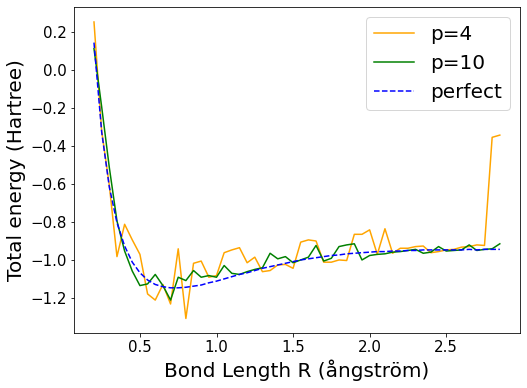

In [11]:
import matplotlib.pylab as plt
from matplotlib import rcParams

style = {
  'legend.fontsize': 20,
  'xtick.labelsize': 15,
  'ytick.labelsize': 15,
  'axes.labelsize': 20,
  'font.size': 20

}
rcParams.update(style)


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Rs, vals_trotter_4, label="p=4", color="orange")
ax.plot(Rs, vals_trotter_10, label="p=10", color="green")
ax.plot(Rs, vals_perfect, label="perfect", color="blue", linestyle='--')
ax.legend(fontsize=20)

ax.set_xlabel("Bond Length R (ångström)")
ax.set_ylabel("Total energy (Hartree)")

The figure seems consistent with Fig. 3. of the [Arxiv:1512.06860](https://arxiv.org/abs/1512.06860) paper.